# Team

Sofien Ben Ayed - 1971009

Zhuofei Kang - 1939634

Maryam El Arfaoui - 1939476


# 1 - Overview

Twitter is a mix of social network and microblogging. In this network, people post information and communicate among themselves through messages, called tweets, that can contain up to 280 characters. In this assignment, *we will implement a prototype that can detect if an airline company is positively or negatively mentioned in a tweet*. 



# 2 - Sentiment Analysis Model (13 points)

In the literature, the task of extracting the sentiment of a text is called *sentiment analysis*. We will implement a bag-of-words (BoW) model for this task.

## 2.1 -  Setup

Please run the code below to install the packages needed for this assignment.

In [1]:
# If you want, you can use anaconda and install after nltk library
# pip install --user numpy
# pip install --user sklearn
# pip install --user scipy
# pip install --user nltk


#python
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kkkan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kkkan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kkkan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\kkkan\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 2.2 - Dataset

Please download the zip file in the following url: https://drive.google.com/file/d/1iGmESwPXpO3sIZFGOCrysxJ27AHdly-Y/view?usp=sharing

In this zip file, there are 2 files:
1. train.tsv: training dataset
2. dev.tsv: validation dataset

Each line of the files has the following information about a tweet: *tweet id*, *user id*, *label* and *message text*.

There are three labels in the dataset: *negative*, *neutral* and *positive*. We represent each one of these labels as 0, 1 and 2 respectively.

In the code above read the training and validation datasets.

In [2]:
import codecs
import re

def load_dataset(path):
    dtFile = codecs.open(path, 'r')
    
    x = []
    y = []
    
    for l in dtFile:
        sid, uid, label,text = re.split(r"\s+", l, maxsplit=3)
        
        text = text.strip()
        
        # Remove not available
        if text == "Not Available":
            continue
        
        x.append(text)
        
        if label == "negative": 
            y.append(0)
        elif label == "neutral": 
            y.append(1)
        elif label == "positive": 
            y.append(2)
        
    assert len(x) == len(y)
            
    return x,y
            

# Path of training dataset
trainingPath="C:/Anaconda/data_mining/sentiment_analysis/train_data.tsv"

# Path of validation dataset
validationPath="C:/Anaconda/data_mining/sentiment_analysis/dev_data.tsv"

training_X, training_Y = load_dataset(trainingPath)
validation_X, validation_Y = load_dataset(validationPath)

## 2.3 - Preprocessing

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.

### 2.3.1 - Tokenization

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


#### 2.3.1.1 - Question 1 (0.5 point) 

Implement the SpaceTokenizer and NLTKTokenizer tokenizers: 
- **SpaceTokenizer** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **NLTKTokenizer** uses the default method of the nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.

**All tokenizers have to lowercase the tokens.**

In [3]:
import nltk

class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.
    
    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    
    def tokenize(self, text):

        tokens = text.replace('\n',' ').replace('\t',' ').split()
        
        # Have to return a list of tokens
        return tokens
        
class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """
    
    def tokenize(self, text):

        tokens = nltk.word_tokenize(text)
        
        # Have to return a list of tokens
        return tokens

# test = NLTKTokenizer()
# print(test.tokenize("hello\tworld of\nNLP"))

### 2.3.2 - Stemming

In the tweets *"I should have bought a new shoes today"* and *"I spent too much money buying games"*, the words *"buy"* and *"bought"* represent basically the same concept. Considering both words as different can unnecessarily increase the dimensionality of the problem and can negatively impact the performance of simple models. Therefore, a unique form (e.g., the root buy) can represent both words. The process to convert words with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*.

#### 2.3.2.1 - Question 2 (0.5 point) 

Retrieve the stems of the tokens using the attribute *stemmer* from the class *Stemmer*.

In [1]:
from nltk.stem.snowball import SnowballStemmer

class Stemmer(object):
    
    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        stemTokens = []
        for word in tokens:
            stemTokens.append(self.stemmer.stem(word))
        # Have to return a list of stems
        return stemTokens

# test = Stemmer()
# print(test.stem(["hello", "fair", "fairly"]))

### 2.3.3 - Twitter preprocessing

Sometimes only applying the default NLP preprocessing steps is not enough. Data for certain domains can have peculiar characteristics which requires specific preprocessing steps to remove the noise and create a more suitable format for the models. 

In NLP, methods store a set of words, called dictionary, and all the words out of the dictionary are considered as unknown. In this assignment, the feature space dimensionality of a model is directly related to the number of words in the dictionary. Since high-dimensional spaces can suffer from the curse of dimensionality, our goal is to create preprocessing steps that decrease vocabulary size.  

#### 2.3.3.1 - Question 3 (2.0 points)

Briefly explain and implement at least two preprocessing steps that reduce the dictionary size (number of unique words). These preprocessing steps must be related to the specific characteristic of the Twitter data. Therefore, for instance, the stop words removal will not be accepted as a preprocessing step.

In [2]:
class TwitterPreprocessing(object):
    
    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        
        # Remove every mentions to another profile
        # Indeed, the name of a profile doesn't give much information and just increases the dictionary size
        # On Twitter, a mention always begin by "@"
        tweet = ' '.join(word for word in tweet.split() if word[0]!='@')
        
        # Remove every tags
        # Indeed, most tags are created by the users and are an aggregation of several words
        # Eliminate them reduce the dictionary size but a better way would be to decompose the words if there are
        # On Twitter, a tag always begin by "#"
        tweet = ' '.join(word for word in tweet.split() if word[0]!='#')
        
        # return the preprocessed twitter
        return tweet

# test = TwitterPreprocessing()
# print(test.preprocess("Hello @jo it's me ? #funnyhere"))

### 2.3.3  Pipeline

The pipeline is sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. We implement the class *PreprocessingPipeline* that apply the tokenizer, twitter preprocessing and stemer to the text.

**Feel free to change the preprocessing order.**

In [6]:
class PreprocessingPipeline:
    
    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer= NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing() if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None
    
    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        if self.twitterPreprocesser:
            tweet = self.twitterPreprocesser.preprocess(tweet)
        
        tokens = self.tokenizer.tokenize(tweet)

        if self.stemmer:
            tokens = self.stemmer.stem(tokens)
            
        return tokens
    

## 2.4 N-grams

An n-gram is a contiguous sequence of *n* tokens from a text. Thus, for instance,the sequence *"bye as"* and *"walked through"* are example of 2-grams from the sentence *"He said bye as he walked through the door ."*. 1-gram, 2-gram and 3-gram are, respectively, called unigram, bigram and trigram. We list all the possible unigram, bigram and trigram from the *"He said bye as he walked through the door ."*:

- Unigram: ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
- Bigram: ["He said", "said bye", "bye as", "as he", "he walked", "walked through", "through the", "the door", "door ."] 
- Trigram: ["He said bye", "said bye as", "bye as he", "as he walked", "he walked through", "walked through the", "through the door", "the door ."] 


### 2.4.1 - Question 4 (1 point)

Implement bigram and trigram.

**For this exercise, you cannot use any external python library (e.g., scikit-learn).**

In [4]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    bigrams = []
    
    for i in range(len(tokens)-1):
        bigrams.append(tokens[i] + " " + tokens[i+1])
        
    return bigrams

def trigram(tokens):
    """
    tokens: a list of strings
    """
    trigrams = []
    
    for i in range(len(tokens)-2):
        trigrams.append(tokens[i] + " " + tokens[i+1] + " " + tokens[i+2])
        
    return trigrams
    
# test = ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
# print(bigram(test))
# print(trigram(test))

## 2.5 Bag-of-words

Logistic regression, SVM and other well-known models only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two tweets: ”Board games are much better than video games” and ”Pandemic is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | pandemic | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

### 2.5.1 - Question 5 (2 points)

Implement the bag-of-words model that weights the vector with the absolute word frequency.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)
**

In [8]:
import numpy as np
from scipy.sparse import csr_matrix

class CountBoW(object):
    
    def __init__(self, pipeline, bigram=False, trigram=False, words_indexed={}):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words_indexed = words_indexed
        
    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, relates each unigram, bigram or trigram 
        to a specific integer and transforms the text in a vector. 
        Vectors are weighted using the token frequencies in the sentence.
        
        X: a list that contains tweet contents
        
        :return: a list of vectors
        """
        
        # A list of lists of tokens of each tweet
        tweets_tokenized = []
        
        for tweet in X:
            # Preprocess of data
            tokens = self.pipeline.preprocess(tweet)
            
            # List of tokens of the current tweet
            all_tokens = []
            
            for token in tokens:
                all_tokens.append(token)
            
            if self.bigram:
                # Adding bigrams
                bigrams = bigram(tokens)
                for token in bigrams:
                    all_tokens.append(token)
                    
            if self.trigram:
                # Adding trigrams
                trigrams = trigram(tokens)
                for token in trigrams:
                    all_tokens.append(token)
                    
            tweets_tokenized.append(all_tokens)
        
        # The vocabulary is put in a set
        set_all_words = set()
        for tweet in tweets_tokenized:
            for word in tweet:
                set_all_words.add(word)
        
        # Each word of the vocabulary is associated to an integer
        all_words = list(set_all_words)
        words_indexed = {}
        i = 0
        for word in all_words:
            words_indexed[word] = i
            i += 1
        
        # The vocabulary-integer associations are saved
        self.words_indexed = words_indexed
        
        # Every tweet is converted to bag-of-words vector
        indptr = [0]
        indices = []
        data = []

        for tweet in tweets_tokenized:
            for token in tweet:
                index = words_indexed[token]
                indices.append(index)
                data.append(1)
            indptr.append(len(indices))
        
        bow = csr_matrix((data, indices, indptr), dtype=int).toarray()
        
        return bow
        
    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  transforms the text in a list of integer.
        Vectors are weighted using the token frequencies in the sentence.
        
        X: a list of vectors
        
        :return: a list of vectors
        """
        
        # A list of lists of tokens of each tweet
        tweets_tokenized = []
        
        for tweet in X:
            # Preprocess of data
            tokens = self.pipeline.preprocess(tweet)
            
            # List of tokens of the current tweet
            all_tokens = []
            
            for token in tokens:
                all_tokens.append(token)
            
            if self.bigram:
                # Adding bigrams
                bigrams = bigram(tokens)
                for token in bigrams:
                    all_tokens.append(token)
                    
            if self.trigram:
                # Adding trigrams
                trigrams = trigram(tokens)
                for token in trigrams:
                    all_tokens.append(token)
                    
            tweets_tokenized.append(all_tokens)
        
        indptr = [0]
        indices = []
        data = []

        for tweet in tweets_tokenized:
            for token in tweet:
                if token in self.words_indexed:
                    index = self.words_indexed[token]
                    indices.append(index)
                    data.append(1)
            indptr.append(len(indices))
        
        bow = csr_matrix((data, indices, indptr), dtype=int, shape=(len(tweets_tokenized), len(self.words_indexed))).toarray()
        
        return bow
      
        
# testSentences = ["Board games are much better than video games", "Pandemic is an awesome game!"]
# test = CountBoW(PreprocessingPipeline(True, True, True))
# validation = ["I love this board game!"]
# test1 = test.fit_transform(testSentences)

### 2.5.2 - TF-IDF

Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.

TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.




### 2.5.2.1 - Question 6 (3 points)

Implement a bag-of-words model that weights the vector using TF-IDF.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)**

In [5]:
import math

class TFIDFBoW(object):
    
    def __init__(self, pipeline, bigram=False, trigram=False, words_indexed={}, IDF=[]):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.words_indexed = words_indexed
        self.IDF = IDF

        
    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, calculates the IDF and TF and 
        transforms the text in vectors. Vectors are weighted using TF-IDF method.
        
        X: a list that contains tweet contents
        
        :return: a list that contains the list of integers
        """
        
        # A list of lists of tokens of each tweet
        tweets_tokenized = []
        
        for tweet in X:
            # Preprocess of data
            tokens = self.pipeline.preprocess(tweet)
            
            # List of tokens of the current tweet
            all_tokens = []
            
            for token in tokens:
                all_tokens.append(token)
            
            if self.bigram:
                # Adding bigrams
                bigrams = bigram(tokens)
                for token in bigrams:
                    all_tokens.append(token)
                    
            if self.trigram:
                # Adding trigrams
                trigrams = trigram(tokens)
                for token in trigrams:
                    all_tokens.append(token)
                    
            tweets_tokenized.append(all_tokens)
        
        # The vocabulary in a set
        set_all_words = set()
        for tweet in tweets_tokenized:
            for word in tweet:
                set_all_words.add(word)
        
        # Each word of the vocabulary is associated to an integer
        all_words = list(set_all_words)
        words_indexed = {}
        i = 0
        for word in all_words:
            words_indexed[word] = i
            i += 1
        
        # The vocabulary-integer associations are saved
        self.words_indexed = words_indexed
        
        # Every tweet is converted to bag-of-words vector
        indptr = [0]
        indices = []
        data = []

        for tweet in tweets_tokenized:
            for token in tweet:
                index = words_indexed[token]
                indices.append(index)
                data.append(1)
            indptr.append(len(indices))
        
        bow = csr_matrix((data, indices, indptr), dtype=int).toarray()
        
        # The number of tweets
        N = len(tweets_tokenized)
        
        # For each word, the number of tweets cotaining it
        IDF = []
        for i in range(len(words_indexed)):
            count = 0
            for j in range(N):
            #for bag in bow:
                #if bag.toarray()[0][i] > 0:
                if bow[j][i] > 0:
                    count += 1
            IDF.append(math.log(N/count))
        
        # The IDF for each word is saved
        self.IDF = IDF
        
        indptr = [0]
        indices = []
        data = []

        for bag in bow:
            for index, count in enumerate(bag):
                if count != 0 and IDF[index] != 0:
                    indices.append(index)
                    data.append(bag[index] * IDF[index])
            indptr.append(len(indices))

        bowTFIDF = csr_matrix((data, indices, indptr), dtype=float)#.toarray()
        print("##4")
        return bowTFIDF
        
    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  
            transforms the text in a list of integer.
        
        X: a list of vectors
        
        :return: a list of vectors
        """        
        
        # A list of lists of tokens of each tweet
        tweets_tokenized = []
        
        for tweet in X:
            # Preprocess of data
            tokens = self.pipeline.preprocess(tweet)
            
            # List of tokens of the current tweet
            all_tokens = []
            
            for token in tokens:
                all_tokens.append(token)
            
            if self.bigram:
                # Adding bigrams
                bigrams = bigram(tokens)
                for token in bigrams:
                    all_tokens.append(token)
                    
            if self.trigram:
                # Adding trigrams
                trigrams = trigram(tokens)
                for token in trigrams:
                    all_tokens.append(token)
                    
            tweets_tokenized.append(all_tokens)

        indptr = [0]
        indices = []
        data = []

        for tweet in tweets_tokenized:
            for token in tweet:
                if token in self.words_indexed:
                    index = self.words_indexed[token]
                    indices.append(index)
                    data.append(1)
            indptr.append(len(indices))

        bow = csr_matrix((data, indices, indptr), dtype=int, shape=(len(tweets_tokenized), len(self.words_indexed))).toarray()

        indptr = [0]
        indices = []
        data = []
        
        for bag in bow:
            for index, count in enumerate(bag):
                if count != 0 and self.IDF[index] != 0:
                    indices.append(index)
                    data.append(bag[index] * self.IDF[index])
            indptr.append(len(indices))
        
        bowTFIDF = csr_matrix((data, indices, indptr), dtype=float, shape=(len(tweets_tokenized), len(self.words_indexed)))#.toarray()
        
        return bowTFIDF

# testSentences = ["Board games are much better than video games", "Pandemic is an awesome game!"]
# test = TFIDFBoW(PreprocessingPipeline(True, True, True))
# validation = ["I love this board game!"]
# print(test.fit_transform(testSentences))
# print(test.transform(validation))

## 2.6 - Classifier using BoW

We are going to use logistic regression as a classifier. Read the following page to now more about this classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


The method *train_evaluate* trains and evaluates the logistic regression model.

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """
    
    classifier = LogisticRegression()
    
    training_rep = bowObj.fit_transform(training_X)
    #dicSize = len(training_rep[0])
    dicSize = training_rep.get_shape()[1]
    
    classifier.fit(training_rep, training_Y)
   
    trainAcc = accuracy_score(training_Y,classifier.predict(training_rep))
    validationAcc = accuracy_score(validation_Y,classifier.predict(bowObj.transform(validation_X)))
    
    return classifier, trainAcc, validationAcc, dicSize


### 2.6.1 - Question 7 (4 points)

Train and calculate the logistic regression accuracy in the *training and validation dataset* using each one of the following configurations:
    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram
Besides the accuracy, you have to report the dictionary size for each one of configurations. Finally, describe the results found by you and answer the following questions:
- Which preprocessing has helped the model? Why?
- TF-IDF has achieved a better performance than CountBoW? If yes, why do you think that this has occurred? 
- Has the bigram and trigram improved the performance? If yes, can you mention the reasons of this improvement?

In [12]:
test1 = train_evaluate(training_X, training_Y, validation_X, validation_Y, CountBoW(PreprocessingPipeline(False, False, False)))

D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [13]:
test2 = train_evaluate(training_X, training_Y, validation_X, validation_Y, CountBoW(PreprocessingPipeline(True, False, False)))

D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [37]:
test3 = train_evaluate(training_X, training_Y, validation_X, validation_Y, TFIDFBoW(PreprocessingPipeline(True, False, False)))

##1
##2
##3
##4


D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [39]:
test4 = train_evaluate(training_X, training_Y, validation_X, validation_Y, TFIDFBoW(PreprocessingPipeline(True, False, True)))

##1
##2
##3
##4


D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [40]:
test5 = train_evaluate(training_X, training_Y, validation_X, validation_Y, TFIDFBoW(PreprocessingPipeline(True, True, True)))

##1
##2
##3
##4


D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [41]:
test6 = train_evaluate(training_X, training_Y, validation_X, validation_Y, TFIDFBoW(PreprocessingPipeline(True, True, True), True))

##1
##2
##3
##4


D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [42]:
test7 = train_evaluate(training_X, training_Y, validation_X, validation_Y, TFIDFBoW(PreprocessingPipeline(True, True, True), True, True))

##1
##2
##3
##4


D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programmes\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [43]:
trainAccs = [test1[1], test2[1], test3[1], test4[1], test5[1], test6[1], test7[1]]
validationAccs = [test1[2], test2[2], test3[2], test4[2], test5[2], test6[2], test7[2]]
dicSizes = [test1[3], test2[3], test3[3], test4[3], test5[3], test6[3], test7[3]]
print(trainAccs)
print(validationAccs)
print(dicSizes)

[0.9950124688279302, 0.9900249376558603, 0.9992665395335192, 0.9992665395335192, 0.9988264632536307, 0.9992665395335192, 0.9992665395335192]
[0.5948808473080318, 0.6275375110326566, 0.6257722859664607, 0.6363636363636364, 0.6125330979699912, 0.6328331862312445, 0.6204766107678729]
[32157, 24141, 24141, 17677, 14197, 90673, 208662]


**Training Accuracies** : 

[0.9950124688279302, 0.9900249376558603, 0.9992665395335192, 0.9992665395335192, 0.9988264632536307, 0.9992665395335192, 0.9992665395335192]

**Validation Accuracies** :

[0.5948808473080318, 0.6275375110326566, 0.6257722859664607, 0.6363636363636364, 0.6125330979699912, 0.6328331862312445, 0.6204766107678729]

**Dictionary Sizes** : 

[32157, 24141, 24141, 17677, 14197, 90673, 208662]

**Results description** : 

-the first remark that can be made about the results is that the accuracies of the training file are high compared to those of the validation file, which is quite normal since the model uses the vocabulary of the training file whereas in the test file several significant terms can be overlooked. Also, we can say that there is overfitting because of the very high values of the training accuracies (close to 1).

-we can also say that there is not a big difference between the accuracies of the different methods, however we notice higher values for methods 4 and 6.

-Regarding the size of the dictionary, in fact, its size increases when we introduce the bigram and trigram, and we also note that stemming and twitterpreprossessing make a significant reduction in the size of the dictionary.

**The best preprocessing methods are n°4 and n°6** :

-> TFIDFBoW + NLTKTokenizer + Stemming + unigram

-> TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram

This can be explained by the use of TF-IDF, bigrams and stemming.

**Stemming** allows to reduce the size of the vocabulary and to associate several different words which have the same meaning.

**TF-IDF can achieve a better performance than CountBoW**. Indeed, CountBoW only gives a vector with the number of occurences of each word. This way of counting can lead to some issues. For example, there are some words which are common to every piece of text as "the", "a", "is"... The number of occurences of these one will be high while they don't give us any clue regarding the sentiment expressed. "Awful" is much more interesting but less frequent and therefore has a lower weight in CountBoW. TF-IDF performs better by facing those issues. As the words like "the" and "a" appear in most of the tweets, thet will have low weights while "awful" is rarer and will be considered as more important.

**Using n-grams can improve performance**. Unigrams are words alone but many times a unique word doesn't convey all the information and we use 2 or 3 words to get a complete sense. In our case of sentiment analysis, "not like" is negative but using unigrams will lead us to take into account only "not" and "like" separately. The same happens for locutions and expressions of 2/3 words or more. That's why by using bigrams and trigrams, it performs better : it can get a more global sense of the sentiment expressed.

Finally, we can also say that using NLTKTokenizer is a better choice than our simple SpaceTokenizer : it takes punctuation into account which has as a consequence to reduce the dictionary size.

In [11]:
bestBowObj = TFIDFBoW(PreprocessingPipeline(True, False, True))
bestClassifier = LogisticRegression()
training_rep = bestBowObj.fit_transform(training_X)
bestClassifier.fit(training_rep, training_Y)

##4


C:\Users\kkkan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\kkkan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# 3 Prototype (7 points)

During the last years, *E Corp* has collected tweets to create a dataset to their sentiment analysis tool. Now, airline companies have contracted *E Corp* to analyze the consumer opinion about them. Your job is to extract information from the tweet database about the following companies: Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.

*For the prototype, you have to use the best model found in the Section 2.*

## 3.1 Dataset

In https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing, you can find the raw tweet retrieved by E corp.  Each tweet is represented as json that the have attributes listed in the page https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.

** You will answer the question of this section using this tweet database (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing).**

## 3.2 Sentiment Analysis


### 3.2.1 Question 8 (0.5 point)

Implement the method *extract_tweet_content* that extracts the content of each tweet in the database.

In [12]:
import json

def extract_tweet_content(raw_tweet_file):
    """
    Extract the tweet content for each json object
    
    raw_tweet_file: file path that contains all json objects
    
    :return: a list with the tweet contents
    """
    tweets = []
    
    with open(raw_tweet_file) as f:
        for line in f:
            tweets.append(json.loads(line)["text"])
    
    return tweets
    

### 3.2.1 Question 9 (1 points)

Implement the method *detect_airline* that detects the airline companies in a tweet. Besides that, explain your approach to detect the companies and its possible drawbacks.

The detect_airline has to be able to return if none or more than one airline companies are mentioned in a tweet

**Some explanations**

A simple method is used to detect an airline company in a tweet.
All the names are stored in a list and for each name in the list, we check the tweet which is a string, contains the name as a substring (case insensitive).
One drawback of this method is the probability of false positive especially with words in the names of companies that can be used in other contexts.
False negative can also be a problem if acronyms are often used or if people talk about a company without the last word "airlines". For example, "I fly with united" will give a false negative.

In [13]:
def detect_airline(tweet):
    """
    Detect and return the airline companies mentioned in the tweet
    
    tweet: represents the tweet message. Type : string
    
    :return: list of detected airline companies
    """
    airline_companies = ["air france", "american airlines", "british airways", "delta airlines", "southwest airlines", "united airlines", "us airways", "virgin america"]
    
    detected = []
    
    # Not sensitive to uppercase/lowercase
    tweet = tweet.lower()
    
    for company in airline_companies:
        if company in tweet:
            detected.append(company)
    
    # If any company is detected, it will return an empty list
    return detected

# test = "Air france is better than delta"
# print(detect_airline(test))


### 3.2.1 Question 10 (0.5 points)

Implement the method *extract_sentiment* that receives a tweet and extracts its sentiment.

In [14]:
def extract_sentiment(classifier, tweet, bowObj):
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweet: represents the tweet message. Type : string
    
    :return: list of detected airline companies
    """
    
    return classifier.predict(bowObj.transform([tweet]))[0]

# test = "It's so bad!"
# extract_sentiment(bestClassifier, test, bestBowObj)

### 3.2.1 Question 11 (2 points)

Using the *extract_tweet_content*, *detect_airline* and *extract_sentiment*, implement a code that generates a bar chart that contains the number of positive, neutral and negatives tweets for each one of the companies. Briefly describe your bar chart (e.g, which was the company with most negative tweets) and how this chart can help airline companies.   

In [17]:
tweets = extract_tweet_content("e_corp_dataset.txt")

airline_companies = ["air france", "american airlines", "british airways", "delta airlines", "southwest airlines", "united airlines", "us airways", "virgin america"]
    
# Each comany is associated to a triplet counting the number of negative, neutral and positive tweets
counts = {}
for company in airline_companies:
    counts[company] = [0, 0, 0]
    
for tweet in tweets:
    
    airlines = detect_airline(tweet)
    
    # The sentiment is extracted only if airlines are detected
    if len(airlines) > 0:
        sentiment = extract_sentiment(bestClassifier, tweet, bestBowObj)
        for company in airlines:
            counts[company][sentiment] += 1


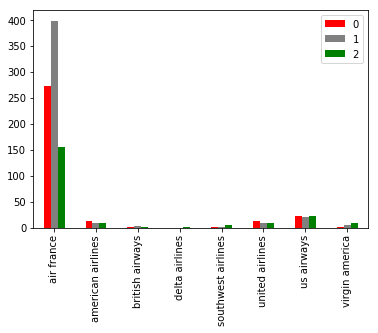

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = []
negative = []
neutral = []
positive = []

for key, value in counts.items():
    X.append(key)
    negative.append(value[0])
    neutral.append(value[1])
    positive.append(value[2])

# Constructing the bar chart composed of 3 bars (negative, neutral and positive) for each company
df = pd.DataFrame(np.c_[negative, neutral, positive], index=X)
df.plot.bar(color = ["red", "grey", "green"])

plt.show()


**DESCRIPTION OF BAR CHART**

-As we obtained a huge quantity of air france tweets compared to other companies, we decided to check the tweets mentioning the company. We found out that most of them were tweets about the accident of the flight 447 which explains the quantity of tweets and the negativity of the tweets.

-For American Airlines, United Airlines, US Airways, the negative tweets dominate, which is supposed to push them to improve their services, perhaps by doing an analysis to detect the complaints that are repeated often, and try to treat them.

-For Virgin America and Southwest Airlines , the postitive tweets dominate. The customers are certainly satisfied by these companies.

-In fact, we may not have enough tweets for British Airways, Delta Airlines and Southwest Airlines to draw any conclusion about the satisfaction of the customers.

## 3.3 - Term Analysis

POS-tagging consists of extracting the part-of-speech (POS) of each token in a sentence. For instance, the table below depicts the part-of-speechs of the sentence *The cat is white!* are.



|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


The part-of-speech can be more complex than what we have learned in the school. Linguistics need to have a more detailed information about systax information of the words in a sentence. For our problem, we do not need this level of information and, thus, we will use a less complex set, called universal POS tags. 

In POS-tagging, each part-of-speech is represented by a tag. You can find the POS tag list used in this assignement at https://universaldependencies.org/u/pos/ .

In [50]:
# NLTK POS-tagger

import nltk


#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
nltk.pos_tag(s,tagset='universal')


[('The', 'DET'), ('cat', 'NOUN'), ('is', 'VERB'), ('white', 'ADJ'), ('!', '.')]

### 3.3.1 Question 12 (2 points)

**Implement a code** that retrieves the top 10 most frequent terms for each airline company. You will only consider the terms that appear in a positive and negative tweets. Besides that, we consider as term:
1. Words that are either an adjective or a noun
2. n-grams that are composed by adjectives followed by a noun (e.g., dirty place) or a noun followed by another noun (e.g.,sports club).

Moreover, **generate a table** with the top 10 most frequent terms and their normalized frequencies(percentage) for each airline company.

**Do not forget to remove the company names from the chart.**

In [45]:
# Extracting the tweets
tweets = extract_tweet_content("e_corp_dataset.txt")
#tweets = extract_tweet_content("test.txt")

airline_companies = ["air france", "american airlines", "british airways", "delta airlines", "southwest airlines", "united airlines", "us airways", "virgin america"]
    
# For each company, a dictionary composed of terms-counts is stored 
terms_by_company = {}
for company in airline_companies:
    terms_by_company[company] = {}

pipeline = PreprocessingPipeline(True, True, False)

for tweet in tweets:
    
    airlines = detect_airline(tweet)
    
    # If at least one company is detected
    if len(airlines) > 0:
        
        sentiment = extract_sentiment(bestClassifier, tweet, bestBowObj)
        
        # We are not interested in neutral tweets
        if sentiment != 1:
            
            # All the terms in the tweet
            terms = []
            
            tokens = pipeline.preprocess(tweet)
            bigrams = bigram(tokens)
            trigrams = trigram(tokens)
            
            # Unigram : adjective or noun
            unigram_tags = nltk.pos_tag(tokens, tagset='universal')
            for tag in unigram_tags:
                if tag[1] == "ADJ" or tag[1] == "NOUN":
                    terms.append(tag[0])
            
            # Bigram : adjective-noun or noun-noun
            for bi in bigrams:
                decomposed = bi.split()
                decomposed_tags = nltk.pos_tag(decomposed, tagset='universal')
                if (decomposed_tags[0][1] == "ADJ" and decomposed_tags[1][1] == "NOUN") or (decomposed_tags[0][1] == "NOUN" and decomposed_tags[1][1] == "NOUN"):
                    terms.append(bi)
            
            # Trigram : adjective-adjective-noun
            for tri in trigrams:
                decomposed = tri.split()
                decomposed_tags = nltk.pos_tag(decomposed, tagset='universal')
                if decomposed_tags[0][1] == "ADJ" and decomposed_tags[1][1] == "ADJ" and decomposed_tags[2][1] == "NOUN":
                    terms.append(tri)
            
            # Updating the counts for each company detected in the tweet
            for company in airlines:
                for term in terms:
                    # We don't take the name of the company itself
                    if term.lower() not in company:
                        if term in terms_by_company[company]:
                            terms_by_company[company][term] += 1
                        else:
                            terms_by_company[company][term] = 1


In [46]:
from collections import Counter

# Each company is associated to a list of the top 10 words with the 10 frequecies associated
table = {}

# Titles of the table rows
index_companies = []

for company in terms_by_company:
    
    index_companies.append(company)
    
    # Calculating the frequencies
    counts = Counter(terms_by_company[company])
    normalized_counts = {term : count / sum(counts.values()) for term, count in counts.items()} #
    top10 = Counter(normalized_counts).most_common(10)
    
    # List : [word, frequeny, word, frequency, ...]
    list_top10 = []
    for count in top10:
        list_top10.append(count[0])
        list_top10.append(count[1])
        
    table[company] = list_top10

# 10 columns for the words and 10 columns for the frequencies
columnNames = []
for i in range(1, 11):
    columnNames.append("word" + str(i))
    columnNames.append("frequency" + str(i))

# Constructing the table
df = pd.DataFrame.from_dict(table, orient='index', columns=columnNames)
print(df)
    

                       word1  frequency1       word2  frequency2  \
air france               sad    0.045177      flight    0.036345   
american airlines     flight    0.027778        time    0.020833   
british airways      Awesome    0.033333         guy    0.033333   
delta airlines      samantha    0.100000       james    0.100000   
southwest airlines   Boardin    0.013889      flight    0.013889   
united airlines       beauty    0.019108       today    0.019108   
us airways            flight    0.035398  experience    0.011799   
virgin america        flight    0.041237       board    0.020619   

                            word3  frequency3     word4  frequency4  \
air france          France flight    0.027514     plane    0.025815   
american airlines            quot    0.013889      bags    0.013889   
british airways               bag    0.033333  security    0.033333   
delta airlines                 Im    0.100000      cool    0.100000   
southwest airlines         Dulle

### 3.3.2 Question 13 (1 point)

The table generated in the Question 12 can lead us to any conclusion about each one of the 9 companies? Can we identify specific events that have occured during the data retrieval?

**Conclusion regarding the table**


This table, by linking it with the previous bar chart can be used by companies to detect the most common complaints among its customers. For example, for American Airlines, the most frequent words are flight and time, which can lead to say that this company needs to improve its travel times and possibly manage delays if they exist. We can also invoke the example of British Airways, which has among the most frequent words "Security", so maybe the company lacks security measures in his travels. However, the table remains insufficient, since we also need to know the whole analysis of the tweets in which these words appear the most, in other words, each word must be linked to the sentiment analysis: positive, negative, and neutral feelings. This to be able to identify if the term refers to something to improve, or something good to keep. (We can't really know if "time" is used in "just in time" or "not in time" for instance).

As explained previously, we discovered that an accident occurred during the data retrieval : the accident of the Air France Flight 447, which explain the most frequent words for Air France (sad, flight, France flight, families...)

# 4 - Bonus (2 points)

Person names, companies names and locations are called named entities. Named-entity recognition (NER) is the task of extracting named entities  classifying them using pre-defined categories. In this bonus section, you will use a Named Entity Recognizer to automatically extract named entities from the tweets. This approach is generic enough to retrieve information about other companies or even product and people names.

**For the bonus, you are free to use any Named Entity Recognizer that has python wrapper or is implemented in python. Moreover, you have to use the tweet database of the previous section (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing)**


## 4.1 - Bonus 2 (1 point)

Implement a code that generates the table with the top 10 most mentioned named entities in the database (this table has to contain the frequencies of the name entities). After that, generates a bar chart that despicts the number of positive, negative and neutral tweets for each one of these 10 named entities. Briefly describe the results found in the bar chart.

*Ignore the named entities related to the following airline companies : Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.*

In [38]:
from collections import Counter
from nltk.tag import StanfordNERTagger
import os
java_path = "C:/Program Files (x86)/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path

#tweets = extract_tweet_content("e_corp_dataset.txt")
#tweets = extract_tweet_content("test.txt")

airline_companies = ["air france", "american airlines", "british airways", "delta airlines", "southwest airlines", "united airlines", "us airways", "virgin america"]
    
# Each entity associated with the number of occurences
all_entities = {}

pipeline = PreprocessingPipeline(True, True, False)

st = StanfordNERTagger('C:/Anaconda/data_mining/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz',
                           'C:/Anaconda/data_mining/stanford-ner-2018-10-16/stanford-ner.jar', encoding='utf-8')

i=0
all_tokens = []

for tweet in tweets[:20000]:
    
    tokens = pipeline.preprocess(tweet)
    
    for token in tokens:
        all_tokens.append(token)
        
    if i%10000 == 0 or i == len(tweets):
        classified = st.tag(all_tokens)
        for word in classified:
            # Classified as "O" means that it is NOT an entity
            # We don't take the name of the company itself
            if word[1] != "O" and word[0].lower() not in airline_companies:
                if word[0] not in all_entities:
                    all_entities[word[0]] = 1
                else:
                    all_entities[word[0]] += 1
        
        all_tokens = []
        
    i+=1
    
counts = Counter(all_entities)
normalized_counts = {entity : count / sum(counts.values()) for entity, count in counts.items()} #

# Retrieving the 11 most common entities and their frequency
top11 = Counter(normalized_counts).most_common(11)

top11_names = []
table11 = []
for entity in top11:
    table11.append(list(entity))
    top11_names.append(entity[0])

# Table of 2 columns containing the top 11 entities and their frequency
df = pd.DataFrame(table11, columns = ['entity', 'frequency'])
print(df)


ss
0
bb
10000
bb
     entity  frequency
0    London   0.006649
1        LA   0.005319
2        US   0.004876
3       New   0.004433
4     David   0.004433
5        UK   0.003989
6   Chicago   0.003989
7      Nick   0.003989
8         &   0.003989
9    Boston   0.003546
10   Google   0.003546


In [39]:
# Same as detect_airline but takes the words to detect as input
def detect_entity(tweet, to_detect):
    detected = []

    for entity in to_detect:
        if entity in tweet:
            detected.append(entity)
    
    return detected

# Each entity is associated to a triplet (counts of neg, neut, pos)
counts = {}
for entity in top11_names:
    counts[entity] = [0, 0, 0]
    
for tweet in tweets:
    entities = detect_entity(tweet, top11_names)
    if len(entities) > 0:
        sentiment = extract_sentiment(bestClassifier, tweet, bestBowObj)
        for entity in entities:
            counts[entity][sentiment] += 1


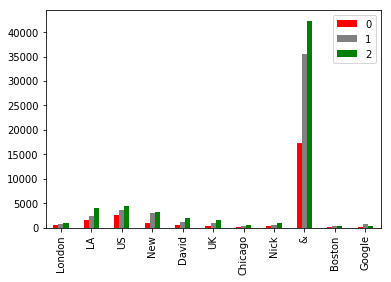

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = []
negative = []
neutral = []
positive = []

for key, value in counts.items():
    X.append(key)
    negative.append(value[0])
    neutral.append(value[1])
    positive.append(value[2])

# Constructing the bar chart for the top 10 entities
df = pd.DataFrame(np.c_[negative, neutral, positive], index=X)
df.plot.bar(color = ["red", "grey", "green"])

plt.show()

(11 entities were displayed because "&" should not really count as an entity even if the NER says so)

We notice that the named entities most mentioned in the tweets are those of the US states, and unlike the first bar chart, here the positive feeling is more present on the tweets, more present even than the neutral feeling except for Google which is more neutral, maybe because it is used in tweets just to mention "type on Google" or "search on Google"...

## 4.2 - Bonus 3 (1 point)

Generate a similar table produced in the Question 12 for the 10 most mentioned named entities in Bonus 2. Can we draw any conclusion about these named entities?

In [42]:
# SAME CODE AS QUESTION 12 BUT USING THE 10 MOST MENTIONED ENTITIES INSTEAD OF AIRLINES

tweets = extract_tweet_content("e_corp_dataset.txt")
#tweets = extract_tweet_content("test.txt")

terms_by_entity = {}
for entity in top11_names:
    terms_by_entity[entity] = {}

pipeline = PreprocessingPipeline(True, True, True)

for tweet in tweets:
    entities = detect_entity(tweet, top11_names)
    if len(entities) > 0:
        sentiment = extract_sentiment(bestClassifier, tweet, bestBowObj)
        if sentiment != 1:
            terms = []
            
            tokens = pipeline.preprocess(tweet)
            
            bigrams = bigram(tokens)
            trigrams = trigram(tokens)
            
            unigram_tags = nltk.pos_tag(tokens, tagset='universal')
            for tag in unigram_tags:
                if tag[1] == "ADJ" or tag[1] == "NOUN":
                    terms.append(tag[0])
            
            for bi in bigrams:
                decomposed = bi.split()
                decomposed_tags = nltk.pos_tag(decomposed, tagset='universal')
                if (decomposed_tags[0][1] == "ADJ" and decomposed_tags[1][1] == "NOUN") or (decomposed_tags[0][1] == "NOUN" and decomposed_tags[1][1] == "NOUN"):
                    terms.append(bi)
            
            for tri in trigrams:
                decomposed = tri.split()
                decomposed_tags = nltk.pos_tag(decomposed, tagset='universal')
                if decomposed_tags[0][1] == "ADJ" and decomposed_tags[1][1] == "ADJ" and decomposed_tags[2][1] == "NOUN":
                    terms.append(tri)
                    
            for entity in entities:
                for term in terms:
                    if term not in entity:
                        if term in terms_by_entity[entity]:
                            terms_by_entity[entity][term] += 1
                        else:
                            terms_by_entity[entity][term] = 1


In [48]:
from collections import Counter

table = {}
index_entities = []
for entity in terms_by_entity:
    index_entities.append(company)
    counts = Counter(terms_by_entity[entity])
    normalized_counts = {term : count / sum(counts.values()) for term, count in counts.items()} #
    top11 = Counter(normalized_counts).most_common(11)
    list_top11 = []
    for count in top11:
        list_top11.append(count[0])
        list_top11.append(count[1])
    if len(list_top11) > 0:
        table[entity] = list_top11

columnNames = []
for i in range(1, 12):
    columnNames.append("word" + str(i))
    columnNames.append("frequency" + str(i))
    
df = pd.DataFrame.from_dict(table, orient='index', columns=columnNames)
print(df)

           word1  frequency1   word2  frequency2 word3  frequency3     word4  \
London    london    0.075162       i    0.066034   day    0.013335      good   
LA             i    0.064183      la    0.022319   day    0.007854      last   
US             i    0.064793  flight    0.009540  good    0.006379     thank   
New          new    0.068773       i    0.045910  moon    0.016410  new moon   
David      david    0.050573    good    0.011002  haha    0.007652      cook   
UK            uk    0.066448       i    0.061166  good    0.009593       day   
Chicago  chicago    0.083527     day    0.009435  good    0.008817      time   
Nick        nick    0.049515    good    0.009069  jona    0.008706       amp   
&              i    0.057638    quot    0.045774   amp    0.044578        lt   
Boston    boston    0.077728       i    0.067269   day    0.009270      good   
Google     googl    0.082165       i    0.054835  http    0.013315      wave   

         frequency4   word5  frequency5

(11 words are displayed just because the first one is the entity itself)

**Can we draw any conclusion about these named entities?**

This table can give an idea of the topics frequently discussed on twitter, and we notice that users talk more about places, and if we link this with the most common words, we can say that they may be interested more to travel, which can be a good opportunity for traveling companies, to do well targeted advertising to users of twitter while taking into consideration the most cited places like London and the United States.

In addition, among the unit names invoked, there is David who refers to David Carradine, an American actor, director and screenwriter found hanged in his room on 4 JUNE 2009, ie during the data retrieval.